# MODEL TRAINING

Using device: cpu
1: 720 train, 180 test images loaded.
10: 720 train, 180 test images loaded.
2: 720 train, 180 test images loaded.
3: 720 train, 180 test images loaded.
4: 720 train, 180 test images loaded.
5: 720 train, 180 test images loaded.
6: 720 train, 180 test images loaded.
7: 720 train, 180 test images loaded.
8: 720 train, 180 test images loaded.
9: 179 train, 45 test images loaded.
A: 800 train, 200 test images loaded.
B: 800 train, 200 test images loaded.
C: 800 train, 200 test images loaded.
D: 800 train, 200 test images loaded.
E: 800 train, 200 test images loaded.
F: 800 train, 200 test images loaded.
G: 1484 train, 372 test images loaded.
H: 800 train, 200 test images loaded.
I: 800 train, 200 test images loaded.
J: 800 train, 200 test images loaded.
K: 800 train, 200 test images loaded.
L: 800 train, 200 test images loaded.
M: 800 train, 200 test images loaded.
N: 800 train, 200 test images loaded.
O: 800 train, 200 test images loaded.
P: 800 train, 200 test images l

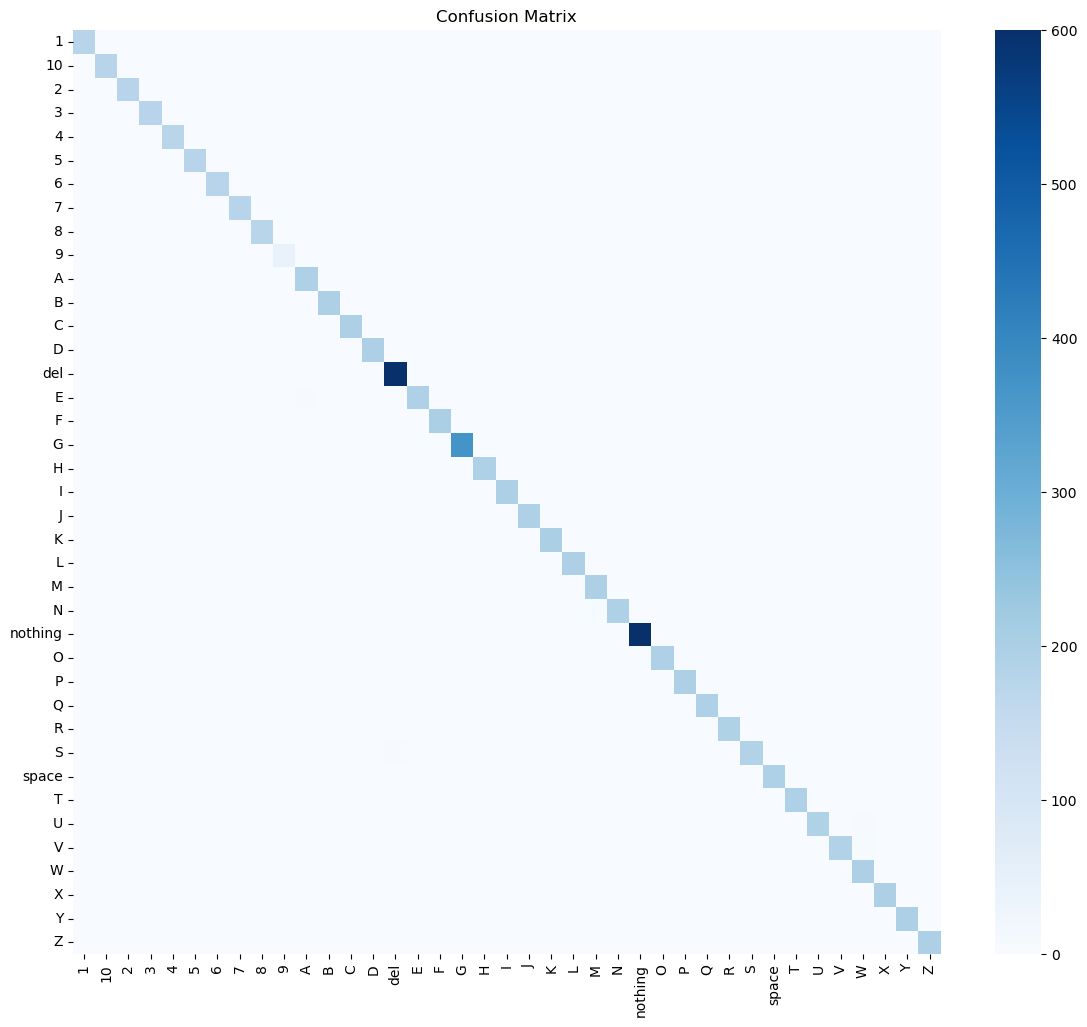

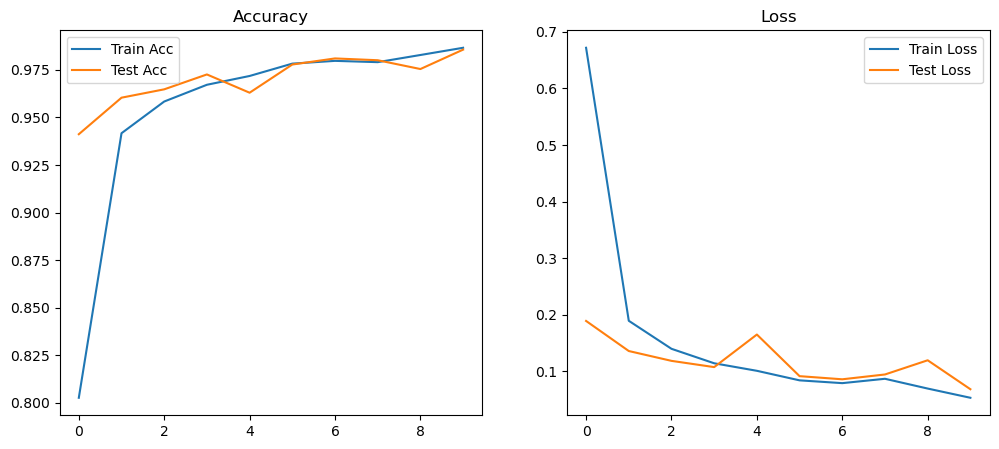

Model saved as 'asl_cnn_39class_cpu.pth'


In [1]:
# 1. IMPORTS
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import random

# 2. DEVICE CONFIG (Force CPU)
device = torch.device("cpu")
print("Using device:", device)

# 3. CLASS LABELS
labels = [
    '1', '10', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I',
    'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q',
    'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]
label_map = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels)

# 4. LOAD IMAGES FROM FOLDERS
def load_data(base_path, image_size=32, train_ratio=0.8):
    X_train, y_train, X_test, y_test = [], [], [], []
    for folder in sorted(os.listdir(base_path)):
        if folder not in label_map:
            continue
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue

        all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(all_images)

        split_idx = int(len(all_images) * train_ratio)
        train_images = all_images[:split_idx]
        test_images = all_images[split_idx:]

        label_idx = label_map[folder]

        for file in train_images:
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X_train.append(img)
                y_train.append(label_idx)

        for file in test_images:
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X_test.append(img)
                y_test.append(label_idx)

        print(f"{folder}: {len(train_images)} train, {len(test_images)} test images loaded.")

    print(f"\nTotal Loaded: {len(X_train)} train and {len(X_test)} test images")
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# 5. LOAD DATA
X_train, y_train, X_test, y_test = load_data("Preprocessed_data", image_size=32, train_ratio=0.8)

# Normalize
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# 6. CUSTOM DATASET
class ASLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).permute(0, 3, 1, 2)  # NHWC -> NCHW
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ASLDataset(X_train, y_train)
test_dataset = ASLDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 7. CNN MODEL
class ASLCNN(nn.Module):
    def __init__(self):
        super(ASLCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128), nn.MaxPool2d(2), nn.Dropout(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256), nn.MaxPool2d(2),

            nn.Flatten(), nn.Dropout(0.2),
            nn.Linear(256 * 4 * 4, 1024), nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = ASLCNN().to(device)

# 8. TRAINING CONFIG
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_acc, test_acc = [], []
train_loss, test_loss = [], []

# 9. TRAINING LOOP
for epoch in range(epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out = model(imgs)
        loss = loss_fn(out, lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)

    acc = correct / total
    train_acc.append(acc)
    train_loss.append(running_loss / len(train_loader))

    # Evaluate
    model.eval()
    correct = total = test_running_loss = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            loss = loss_fn(out, lbls)
            test_running_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)

    acc = correct / total
    test_acc.append(acc)
    test_loss.append(test_running_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc[-1]:.4f} | Test Acc: {test_acc[-1]:.4f}")

# 10. CONFUSION MATRIX
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        out = model(imgs.to(device))
        _, preds = torch.max(out, 1)
        y_true.extend(lbls.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(14, 12))
sns.heatmap(df_cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 11. PLOT TRAINING METRICS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.title("Loss")
plt.legend()
plt.show()

# 12. SAVE MODEL
torch.save(model.state_dict(), "asl_cnn_39class_cpu.pth")
print("Model saved as 'asl_cnn_39class_cpu.pth'")

# Test Maker

In [7]:
import os
import random
import shutil

# === Define labels ===
labels = [
    '1', '10', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I',
    'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q',
    'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]

# === Set base directory to Preprocessed_data next to the script ===
script_dir = os.getcwd()  # Location of the .py file
base_dir = os.path.join(script_dir, "Preprocessed_data")
destination_dir = os.path.join(script_dir, "test")

# === Create test folder ===
os.makedirs(destination_dir, exist_ok=True)

# === Copy one random image per class ===
for class_name in labels:
    class_path = os.path.join(base_dir, class_name)
    
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_image = random.choice(images)
            source_image_path = os.path.join(class_path, selected_image)
            ext = os.path.splitext(selected_image)[1]
            dest_path = os.path.join(destination_dir, f"{class_name}{ext}")
            shutil.copy(source_image_path, dest_path)
            print(f"Copied {selected_image} → test/{class_name}{ext}")
        else:
            print(f"No images found in: {class_name}")
    else:
        print(f"Folder not found: {class_name}")

print("\nAll available classes processed into 'test/' folder.")

Copied 110d1f1a-e49d-4af2-a34f-a729b8e71318.rgb_0000.png → test/1.png
Copied 255e7ab2-4bbf-4571-91fc-577d870ae43b.rgb_0000.png → test/10.png
Copied 368628bd-c464-4e52-8577-eed5ec1ac07d.rgb_0000.png → test/2.png
Copied 7c11bc18-1c96-497a-a48c-e455a232dd77.rgb_0000.png → test/3.png
Copied f44e8e23-25b0-4c5d-973d-e904bc3709f8.rgb_0000.png → test/4.png
Copied c42a9227-8e3b-4085-b93f-86283b6bbd95.rgb_0000.png → test/5.png
Copied 64ac0bdd-7549-4d7e-b8ac-065369bdca47.rgb_0000.png → test/6.png
Copied c59fc3e2-3d61-4ba9-a8ad-df881561d52c.rgb_0000.png → test/7.png
Copied 3de0ae8f-d222-4f32-839a-459b7ef14437.rgb_0000.png → test/8.png
Copied 3f90ab98-0f1e-4e66-a431-b604f6d1608d.rgb_0000.png → test/9.png
Copied A2429.jpg → test/A.jpg
Copied B2328.jpg → test/B.jpg
Copied C2434.jpg → test/C.jpg
Copied D2544.jpg → test/D.jpg
Copied del938.jpg → test/del.jpg
Copied E363.jpg → test/E.jpg
Copied F1792.jpg → test/F.jpg
Copied G1474.jpg → test/G.jpg
Copied H368.jpg → test/H.jpg
Copied I1373.jpg → test/I.jp

# Asl_Predictor

In [9]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np

# 1. CLASS LABELS
labels = [
    '1', '10', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I',
    'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q',
    'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]
num_classes = len(labels)

# 2. CNN CLASS (must match training model)
class ASLCNN(nn.Module):
    def __init__(self):
        super(ASLCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128), nn.MaxPool2d(2), nn.Dropout(0.2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256), nn.MaxPool2d(2),
            nn.Flatten(), nn.Dropout(0.2),
            nn.Linear(256 * 4 * 4, 1024), nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x): return self.model(x)

# 3. LOAD MODEL (CPU)
model = ASLCNN()
model.load_state_dict(torch.load("asl_cnn_39class_cpu.pth", map_location=torch.device("cpu")))
model.eval()

# 4. PREDICT FROM FOLDER
def predict_images_in_folder(folder_path, image_size=32):
    for file in os.listdir(folder_path):
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        path = os.path.join(folder_path, file)
        img = cv2.imread(path)
        if img is None:
            print(f"Couldn't read image: {file}")
            continue
        img = cv2.resize(img, (image_size, image_size)).astype("float32") / 255.0
        img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)  # shape: (1, 3, 32, 32)

        with torch.no_grad():
            output = model(img)
            predicted_idx = torch.argmax(output, 1).item()
            predicted_label = labels[predicted_idx]
            print(f"{file} → {predicted_label}")

# 5. RUN
predict_images_in_folder("test")  

1.png → 1
10.png → 10
2.png → 2
3.png → 3
4.png → 4
5.png → 5
6.png → 6
7.png → 7
8.png → 8
9.png → 9
A.jpg → A
B.jpg → A
C.jpg → C
D.jpg → D
del.jpg → del
E.jpg → E
F.jpg → F
G.jpg → G
H.jpg → H
I.jpg → I
J.jpg → J
K.jpg → K
L.jpg → L
M.jpg → M
N.jpg → N
nothing.jpg → nothing
O.jpg → D
P.jpg → P
Q.jpg → Q
R.jpg → R
S.jpg → S
space.jpg → space
T.jpg → T
U.jpg → U
V.jpg → V
W.jpg → W
X.jpg → X
Y.jpg → Y
Z.jpg → Z
